In [1]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import random  

In [2]:
cfw_dict = {'Amitabhbachan': 0, 'AamirKhan': 1, 'DwayneJohnson': 2, 'AishwaryaRai': 3, 'BarackObama': 4, 'NarendraModi': 5, 'ManmohanSingh': 6, 'VladimirPutin': 7}
opt = {'image_size': 32,'is_grayscale': False,'val_split': 0.75}

def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'], opt['image_size']))
    im = np.array(im)
    im = im / 256
    return im

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path, filename))
            y = filename.split('_')[0]
            y = label_dict[y]
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:", image_list.shape)
    print("Label shape:", y_list.shape)
    return image_list, y_list

In [3]:
dirpath = 'SMAI-Dataset-release/IIIT-CFW/'
X, y = load_data(dirpath)

N, H, W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape(N, -1)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_norm = (X - mean) / std
X_norm = np.array(X_norm)
print(X_norm.shape)
cov_matrix = np.cov(X_norm.T)
eigvals, eigvecs = np.linalg.eig(cov_matrix)
eigpairs = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]
eigpairs.sort(reverse=True, key=lambda x: x[0])
comps = []
explained_variance_ratio = []
for i in range(1, 673):
    comps.append(i)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
(672, 3072)


/home/swayam/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


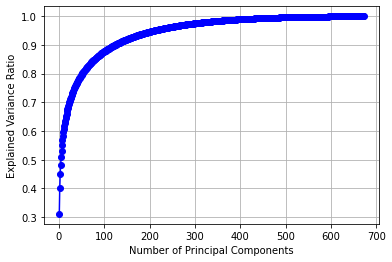

In [4]:
reduced_data_list = []
for num_components in comps:
    sortvecs = np.array([pair[1] for pair in eigpairs[:num_components]])
    reduced_data = np.dot(X_norm, sortvecs.T)
    reduced_data_list.append(reduced_data)
    explained_variance = np.sum(eigvals[:num_components])
    explained_variance_ratio.append(explained_variance / np.sum(eigvals))

plt.ylabel('Explained Variance Ratio')
plt.plot(comps, explained_variance_ratio, marker='o', linestyle='-', color='b', label='Explained Variance Ratio')

plt.xlabel('Number of Principal Components')
plt.grid()
plt.show()

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import random  
import numpy as np

In [6]:
pic_data = np.load('data.npy', allow_pickle = True)
random.shuffle(pic_data)
labels = pic_data[:, 3]
features_vit = pic_data[:, 2]
features_vit = np.vstack(features_vit)
print(labels.shape)
print(features_vit.shape)
X_vit = features_vit
y_vit = labels

(1500,)
(1500, 512)


In [7]:
xmean = np.mean(X_vit, axis = 0)
xstd = np.std(X_vit, axis = 0)

X_vit_norm = (X_vit - xmean)/xstd
xcov_matrix = np.cov(X_vit_norm.T)
xeigvals, xeigvecs = np.linalg.eig(xcov_matrix)

xeigpairs = [(xeigvals[i], xeigvecs[:, i]) for i in range(len(xeigvals))]
xeigpairs.sort(reverse=True, key=lambda x: x[0])

xnum_components = 256
xsortvecs = np.array([pair[1] for pair in xeigpairs[:xnum_components]])
xreduced_data = np.dot(X_vit_norm, xsortvecs.T)
print(xreduced_data.shape)

(1500, 256)


In [8]:
sklearn_knn_model = KNeighborsClassifier()

X_train, X_val, y_train, y_val = train_test_split(xreduced_data, labels, test_size=0.2)
sklearn_knn_model.fit(X_train, y_train)
y_pred_sklearn_knn = sklearn_knn_model.predict(X_val)
accuracy_sklearn_knn = accuracy_score(y_val, y_pred_sklearn_knn)
precision_sklearn_knn = precision_score(y_val, y_pred_sklearn_knn, average='weighted', zero_division=1)
recall_sklearn_knn = recall_score(y_val, y_pred_sklearn_knn, average='weighted', zero_division=1)
f1_sklearn_knn = f1_score(y_val, y_pred_sklearn_knn, average='weighted', zero_division=1)

print("\nsklearn KNN Metrics:")
print("Accuracy:", accuracy_sklearn_knn)
print("Precision:", precision_sklearn_knn)
print("Recall:", recall_sklearn_knn)
print("F1 Score:", f1_sklearn_knn)


sklearn KNN Metrics:
Accuracy: 0.49
Precision: 0.732518722018722
Recall: 0.49
F1 Score: 0.46829539088362615


# Observations:

1) PCA reduces the number of features in the dataset while retaining as much variance as possible. This can be particularly useful when we deal with high-dimensional data as in the case of Pictionary Dataset provided to us. Thus we observe that with fewer dimensions in the data generated after PCA, kNN calculations become comparatively quicker, as there are fewer features which have to be considered for generating the distances.

2) We see that for some hyperparameters, the kNN model on reduced data tends to perform better than the kNN model with the complete data with 512-dimensions(In case of ViT).

In [9]:
accuracy_list = []
real_accuracy_list = []
component_groups = [comps[i:i + 50] for i in range(0, len(comps), 50)]

sklearn_knn_model_real = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
real_train, real_val, y_realtrain, y_realval = train_test_split(X, y, test_size=0.2)
sklearn_knn_model_real.fit(real_train, y_realtrain)
y_realpred = sklearn_knn_model_real.predict(real_val)
accuracy_real = accuracy_score(y_realval, y_realpred)
for i in range(1,673):
    real_accuracy_list.append(accuracy_real)

for i in range(len(reduced_data_list)):
    reduced_data = reduced_data_list[i]
    reduced_data = np.real(reduced_data)
    sklearn_knn_model = KNeighborsClassifier(n_neighbors=10, metric='euclidean')

    assert reduced_data.shape[0] == y.shape[0], "Mismatch in the number of samples between X and y"
    X_train, X_val, y_train, y_val = train_test_split(reduced_data, y, test_size=0.2)

    sklearn_knn_model.fit(X_train, y_train)
    y_pred_sklearn_knn = sklearn_knn_model.predict(X_val)
    accuracy_sklearn_knn = accuracy_score(y_val, y_pred_sklearn_knn)
    precision_sklearn_knn = precision_score(y_val, y_pred_sklearn_knn, average='weighted', zero_division=1)
    recall_sklearn_knn = recall_score(y_val, y_pred_sklearn_knn, average='weighted', zero_division=1)
    f1_sklearn_knn = f1_score(y_val, y_pred_sklearn_knn, average='weighted', zero_division=1)
    accuracy_list.append(accuracy_sklearn_knn)

component_numbers = np.arange(1, 673)  # Component numbers from 1 to 672


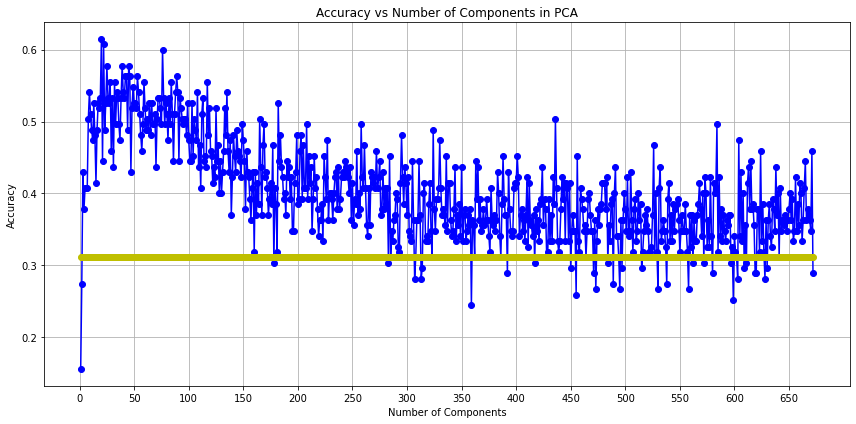

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(component_numbers, accuracy_list, marker='o', linestyle='-', color='b')
plt.plot(component_numbers, real_accuracy_list, marker='o', linestyle='-', color='y')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Components in PCA')
plt.xticks(np.arange(0, 673, step=50))  # Adjust the step value for x-axis labels
plt.grid(True)
plt.tight_layout()
plt.show()

# 1.2 PCA On Pictionary dataset

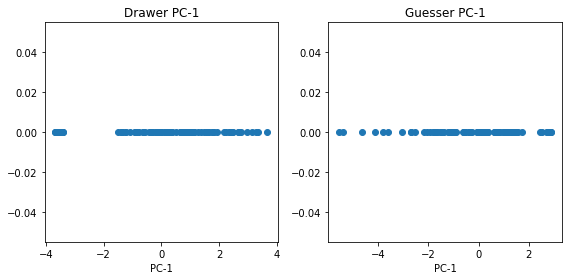

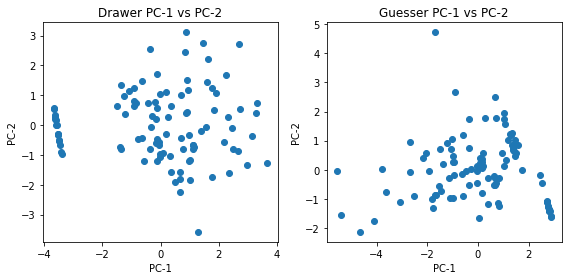

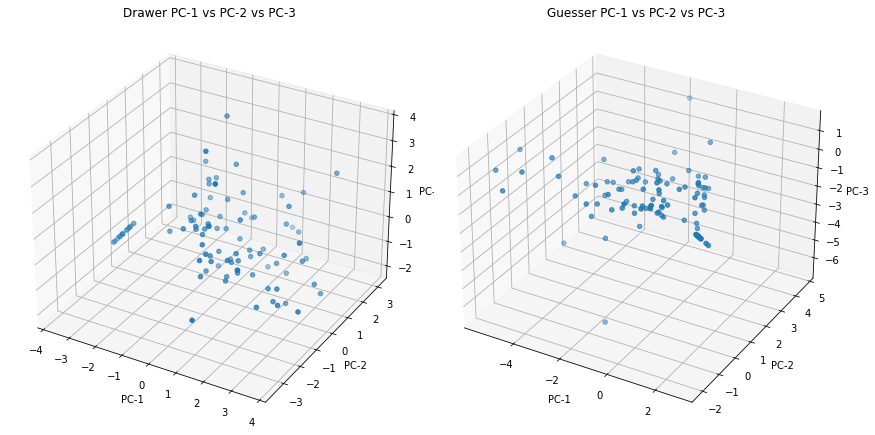

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

drawer_data = pd.read_csv('./smai_assignment_pictionary/drawer_attributes.csv')
guesser_data = pd.read_csv('./smai_assignment_pictionary/guesser_attributes.csv')

drawer_data_std = (np.array(drawer_data) - np.mean(np.array(drawer_data), axis = 0)) / np.std(np.array(drawer_data), axis = 0)
guesser_data_std = (np.array(guesser_data) - np.mean(np.array(guesser_data), axis = 0)) / np.std(np.array(guesser_data), axis = 0)

def compute_covariance_matrix(data):
    return np.cov(data, rowvar=False)

drawer_covariance_matrix = compute_covariance_matrix(drawer_data_std)
guesser_covariance_matrix = compute_covariance_matrix(guesser_data_std)

def calculate_eigenvalues_and_eigenvectors(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    return eigenvalues, eigenvectors

drawer_eigenvalues, drawer_eigenvectors = calculate_eigenvalues_and_eigenvectors(drawer_covariance_matrix)
guesser_eigenvalues, guesser_eigenvectors = calculate_eigenvalues_and_eigenvectors(guesser_covariance_matrix)

k = 3  
drawer_principal_components = drawer_eigenvectors[:, :k]
guesser_principal_components = guesser_eigenvectors[:, :k]

drawer_projected_data = np.dot(drawer_data_std, drawer_principal_components)
guesser_projected_data = np.dot(guesser_data_std, guesser_principal_components)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Drawer PC-1")
plt.scatter(drawer_projected_data[:, 0], np.zeros_like(drawer_projected_data[:, 0]))
plt.xlabel("PC-1")

plt.subplot(122)
plt.title("Guesser PC-1")
plt.scatter(guesser_projected_data[:, 0], np.zeros_like(guesser_projected_data[:, 0]))
plt.xlabel("PC-1")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Drawer PC-1 vs PC-2")
plt.scatter(drawer_projected_data[:, 0], drawer_projected_data[:, 1])
plt.xlabel("PC-1")
plt.ylabel("PC-2")

plt.subplot(122)
plt.title("Guesser PC-1 vs PC-2")
plt.scatter(guesser_projected_data[:, 0], guesser_projected_data[:, 1])
plt.xlabel("PC-1")
plt.ylabel("PC-2")

plt.tight_layout()
plt.show()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Drawer PC-1 vs PC-2 vs PC-3")
ax1.scatter(drawer_projected_data[:, 0], drawer_projected_data[:, 1], drawer_projected_data[:, 2])
ax1.set_xlabel("PC-1")
ax1.set_ylabel("PC-2")
ax1.set_zlabel("PC-3")

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Guesser PC-1 vs PC-2 vs PC-3")
ax2.scatter(guesser_projected_data[:, 0], guesser_projected_data[:, 1], guesser_projected_data[:, 2])
ax2.set_xlabel("PC-1")
ax2.set_ylabel("PC-2")
ax2.set_zlabel("PC-3")

plt.tight_layout()
plt.show()

### Observations

#### After PCA, PC1 i.e. the first principal component captures the most variance of data and indicates the direction in the feature space along which the data varies the most. PC2 captures the second most variance and is orthogonal to PC1. It is independent of PC1 and indicates the second-most important pattern or structure in the data. As the Principal components increase, each subsequent features are captured in decreasing amounts of variance.